## <center> **Livrable n°3 : Captioning d'image** </center>

‎ 

Réalisé par le **groupe n°2** :
- BERTHO Lucien
- BOSACKI Paul
- GAURE Warren
- GRENOUILLET Théo
- VALLEMONT Hugo


‎

---


### **Sommaire**

1. [Mise en contexte](#contexte)
2. [Objectif du livrable](#objectif)
3. [Importation des bibliothèques](#import)
4. [Prétraitement et exploration des données](#pretraitement)
5. [Item #5](#item5)
6. [Item #6](#item6)
7. [Item #7](#item7)
8. [Item #8](#item8)
9. [Item #9](#item9)
10. [Item #10](#item10)

‎ 

---

### 1. <a id='contexte'>Mise en contexte</a>

L’entreprise TouNum est spécialisée dans la numérisation de documents, qu’il s’agisse de textes ou d’images. Ses services sont particulièrement sollicités par des entreprises cherchant à transformer leur base documentaire papier en fichiers numériques exploitables. Aujourd’hui, TouNum souhaite aller plus loin en enrichissant son offre avec des outils basés sur le Machine Learning.

En effet, certains clients disposent d’un volume considérable de documents à numériser et expriment un besoin croissant pour des solutions de catégorisation automatique. Une telle innovation leur permettrait d’optimiser le traitement et l’exploitation de leurs données numérisées. Toutefois, TouNum ne dispose pas en interne des compétences nécessaires pour concevoir et mettre en place ces technologies.

C’est dans ce cadre que notre équipe de spécialistes en Data Science du CESI est sollicitée. Notre mission consiste à développer une première solution intégrant du captioning automatique : un système capable d’analyser des photographies et de générer une légende descriptive de manière autonome.

Heureusement, TouNum possède déjà plusieurs milliers d’images annotées, ce qui constituera une ressource précieuse pour entraîner les modèles de Machine Learning à partir d’un apprentissage supervisé.

---

### 2. <a id='objectif'>Objectif du livrable</a>

TODO

---

### 3. <a id='import'>Importation des bibliothèques</a>

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import collections
import random
import re
import numpy as np
import os
import time
import json
import pickle

from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from pathlib import Path
from glob import glob
from PIL import Image
from tqdm import tqdm

import evaluate as evaluate_metric
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            details = tf.config.experimental.get_device_details(gpu)
            print(f"Nom du GPU détecté : {details.get('device_name', 'Nom inconnu')}")
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Nom du GPU détecté : NVIDIA GeForce RTX 4060 Laptop GPU


---

#### Dossier d'annotation 

Dans cette section on charge les textes associés avec les images du dataset COCO. 

In [3]:
ProjectPath = '/tf/'
#
## Chemin du fichier d'annotations
annotation_file = f"{ProjectPath}dataset_livrable_3/annotations/captions_train2014.json"
#
## Chemin du dossier contenant les images à annoter
PATH = f"{ProjectPath}dataset_livrable_3/train2014/train2014/"

# Chemin du fichier d'annotations
#annotation_file = "/tf/dataset_livrable_3/annotations/captions_train2014.json"

# Chemin du dossier contenant les images à annoter
#PATH = '/tf/dataset_livrable_3/train2014/train2014/'

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaq0+ ue annotation
    caption = '<start> ' + val['caption'] + ' <end>'
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption)

# Print the first 10 values of image_path_to_caption
#for i, (key, value) in enumerate(image_path_to_caption.items()):
#    if os.path.exists(key):
#        if i == 10:
#            break
#        print(f"{key}: {value}")
#        img = Image.open(key)
#        plt.imshow(img)
#        plt.axis("off")
#        plt.show()
    
# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:3000]

# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list)
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list))


---

#### Chargement des images et prétraitement

Ici nous allons charger les images, ainsi que les prétraiter en créant un fichier qui contient les features importantes de l'image

In [4]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(inputs = new_input, outputs = hidden_layer)

# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

I0000 00:00:1745562097.320447     539 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
  0%|          | 0/188 [00:00<?, ?it/s]I0000 00:00:1745562099.517815     539 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-25 06:21:40.748238: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
100%|██████████| 188/188 [01:10<00:00,  2.67it/s]


---

#### Tokenizer

Le tokenizer sert à transformer les différents mots en index et inversement.

In [5]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 5000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)
    
# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)

---

#### Création des jeux d'entrainement

On créer un dataset en faisant un fractionnement aléatoire 80% pour la formation et 20% pour la validation.

In [6]:
img_to_cap_vector = collections.defaultdict(list)
# Creation d'un dictionnaire associant les chemins des images avec (fichier .npy) aux annotationss
# Les images sont dupliquées car il y a plusieurs annotations par image
print(len(img_name_vector), len(cap_vector))
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

"""
Création des datasets de formation et de validation en utilisant 
un fractionnement 80-20 de manière aléatoire
""" 
# Prendre les clés (noms des fichiers d'images traites), *celles-ci ne seront pas dupliquées*
img_keys = list(img_to_cap_vector.keys())
# Diviser des indices en entrainement et test
slice_index = int(len(img_keys) * 0.8)
img_name_train_keys = img_keys[:slice_index]
img_name_val_keys = img_keys[slice_index:]

"""
Les jeux d'entrainement et de tests sont sous forme
de listes contenants les mappings :(image prétraitée ---> jeton d'annotation(mot) )
"""

# Boucle pour construire le jeu d'entrainement
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    # Duplication des images en le nombre d'annotations par image
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Boucle pour construire le jeu de test
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

15007 15007


(12006, 12006, 3001, 3001)

---

#### Chargement des fichiers prétraité

Dans cette section on charge les fichiers qui ont été créer lors du prétraitement et on mélange les données en batch aléatoire.

In [7]:
# N'hésitez pas à modifier ces paramètres en fonction de votre machine
BATCH_SIZE = 64 # taille du batch
BUFFER_SIZE = 1000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 512 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

---

#### Encoder

L'encoder CNN permet de transmettre les caractéristiques trouvé lors du prétraitement et de les envoyer vers une couche dense. 

In [8]:
@tf.keras.utils.register_keras_serializable('CNN_Encoder')
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim, **kwargs):
        super(CNN_Encoder, self).__init__(**kwargs)
        self.embedding_dim = embedding_dim
        # forme après fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    def get_config(self):
        config = super(CNN_Encoder, self).get_config()
        config.update({
            'embedding_dim': self.embedding_dim,
        })
        return config

---

#### Decodeur

L'attention est ce qui permet de choisir dynamiquement une partie de l'image pour chaque mot généré.  
Il utilise trois couches dense, où deux font la $units$ neuronnes et une qui est de un neuronnes

In [9]:
@tf.keras.utils.register_keras_serializable('BahdanauAttention')
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)

        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = tf.nn.tanh(
                self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # Cela vous donne un score non normalisé pour chaque caractéristique de l'image.
        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights
    
    def get_config(self):
        config = super(BahdanauAttention, self).get_config()
        config.update({
            units: self.units,
        })
        return config

Le décodeur RNN est la partie qui génère la réponse mot par mot. Il reçoit l'information résumé par l'encodeur, le contexte de l'attention et le mot précédant. Avec tous cela il génère le prochain mot de la phrase.

In [10]:
@tf.keras.utils.register_keras_serializable('RNN_Decoder')
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, use_lstm=False, **kwargs):
        super(RNN_Decoder, self).__init__(**kwargs)
        self.units = units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.use_lstm = use_lstm

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        if not use_lstm:
            self.layer = tf.keras.layers.GRU(
                self.units,
                return_sequences=True,
                return_state=True,
                activation='tanh',
                recurrent_activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                recurrent_initializer='orthogonal',
                bias_initializer='zeros',
                unroll=True,
            )
        else:
            self.layer = tf.keras.layers.LSTM(
                self.units,
                return_sequences=True,
                return_state=True,
                activation='tanh',
                recurrent_activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                recurrent_initializer='orthogonal',
                bias_initializer='zeros',
                unroll=True,
            )

        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        context_vector = tf.expand_dims(context_vector, 1)
        
        x = tf.concat([context_vector, x], axis=-1)

        if not self.use_lstm:
            x = self.fc1(x)
            output, state = self.layer(x)
            y = tf.reshape(output, (-1, output.shape[2]))
        else:
            output, state, _ = self.layer(x)
            y = self.fc1(output)
            y = tf.reshape(y, (-1, y.shape[2]))

        y = self.fc2(y)

        return y, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

    def get_config(self):
        config = super(RNN_Decoder, self).get_config()
        config.update({
            'embedding_dim': self.embedding_dim,
            'units': self.units,
            'vocab_size': self.vocab_size,
            'use_lstm': self.use_lstm
        })
        return config

---

Ici on créer les éléments définis précédement.

In [11]:
embedding_dim = 256
units = 512
vocab_size = top_k + 1

# Création de l'encodeur (CNN)
encoder = CNN_Encoder(embedding_dim)

# Création du décodeur (RNN avec attention)
decoderLSTM = RNN_Decoder(embedding_dim, units, vocab_size, use_lstm=True)
decoderGRU = RNN_Decoder(embedding_dim, units, vocab_size, use_lstm=False)

L'optimizeur est l'algorithme qui met à jour les poids lors de l'entrainement. Son role est de minimiser la fonction de perte loss, en ajustant les poids et le biais grace à la descente de gradient.

In [12]:
# Optimiseur ADAM
optimizer_LSTM = tf.keras.optimizers.Adam()
optimizer_GRU = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

---

#### Entrainement

Le code si dessous est une étape de l'entrainement, on initialise l'entrée du décodeur et on calcule la loss et le gradient pour mettre à jour les poids.

In [13]:
def train_step(img_tensor, target, encoder, decoder, optimizer):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    # Enregistrement de la loss pour chaque batch
    return loss, total_loss

In [14]:
def train_model(encoder, decoder, optimizer, dataset, epochs = 50, early_stopping = None):
    loss_plot = []
    strike = 0
    best_loss = float('inf')
    
    checkpoint_path = "./checkpoints/model"
    ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

    # création des fichiers pour l'early stopping
    if early_stopping != None and not os.path.exists(f"{ProjectPath}/checkpoints/encoder.weights.h5"):
        Path(f'{ProjectPath}/checkpoints/encoder.weights.h5').touch()

    if early_stopping != None and not os.path.exists(f"{ProjectPath}/checkpoints/decoder.weights.h5"):
        Path(f'{ProjectPath}/checkpoints/decoder.weights.h5').touch()

    #if ckpt_manager.latest_checkpoint:
    #    ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()

    for epoch in range(epochs):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target, encoder, decoder, optimizer)
            total_loss += t_loss

            #if batch % 50 == 0:
                #print('Epoch {}, Batch {}, Batch Loss {:.4f}, Time taken {:.2f} mins'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1]), (time.time() - start)/60))

        epoch_loss = total_loss / num_steps
        loss_plot.append(epoch_loss)

        # Sauvegarde du modèle uniquement si la perte est meilleure
        if float('%.2f' % (epoch_loss)) < best_loss: # Si vous trouver une meilleur façon pour arrondir le float, n'hésitez pas à le changer
            strike = 0
            best_loss = float('%.2f' % (epoch_loss))
            encoder.save_weights(f"{ProjectPath}/checkpoints/encoder.weights.h5")
            decoder.save_weights(f"{ProjectPath}/checkpoints/decoder.weights.h5")
            ckpt_save_path = ckpt_manager.save()
        else:
            strike += 1
            if early_stopping != None and strike >= early_stopping:
                #encoder.load_weights(f"{ProjectPath}/checkpoints/encoder.weights.h5")
                #decoder.load_weights(f"{ProjectPath}/checkpoints/decoder.weights.h5")
                print("Early stopping")
                break
        print('Result Epoch {}, Best Loss {}, Epoch Loss {}, Time taken {:.2f} mins, strike {}'.format(epoch + 1, best_loss, float('%.2f' % (epoch_loss)), (time.time() - start)/60, strike))
    
    return [loss_plot, best_loss, encoder, decoder, optimizer]

2025-04-25 06:25:23.848241: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Result Epoch 1, Best Loss 1.65, Epoch Loss 1.65, Time taken 2.57 mins, strike 0
Result Epoch 2, Best Loss 1.31, Epoch Loss 1.31, Time taken 2.73 mins, strike 0


2025-04-25 06:30:34.206015: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Result Epoch 3, Best Loss 1.18, Epoch Loss 1.18, Time taken 2.45 mins, strike 0
Result Epoch 4, Best Loss 1.09, Epoch Loss 1.09, Time taken 2.48 mins, strike 0
Result Epoch 5, Best Loss 1.03, Epoch Loss 1.03, Time taken 2.47 mins, strike 0
Result Epoch 6, Best Loss 0.96, Epoch Loss 0.96, Time taken 2.55 mins, strike 0


2025-04-25 06:40:51.030766: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Result Epoch 7, Best Loss 0.91, Epoch Loss 0.91, Time taken 2.77 mins, strike 0
Result Epoch 8, Best Loss 0.86, Epoch Loss 0.86, Time taken 2.59 mins, strike 0
Result Epoch 9, Best Loss 0.81, Epoch Loss 0.81, Time taken 2.52 mins, strike 0
Result Epoch 10, Best Loss 0.77, Epoch Loss 0.77, Time taken 2.60 mins, strike 0
Result Epoch 11, Best Loss 0.72, Epoch Loss 0.72, Time taken 2.58 mins, strike 0
Result Epoch 12, Best Loss 0.68, Epoch Loss 0.68, Time taken 2.61 mins, strike 0
Result Epoch 13, Best Loss 0.65, Epoch Loss 0.65, Time taken 2.54 mins, strike 0
Result Epoch 14, Best Loss 0.61, Epoch Loss 0.61, Time taken 2.61 mins, strike 0


2025-04-25 07:01:29.050161: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Result Epoch 15, Best Loss 0.57, Epoch Loss 0.57, Time taken 2.58 mins, strike 0
Result Epoch 16, Best Loss 0.54, Epoch Loss 0.54, Time taken 2.50 mins, strike 0
Result Epoch 17, Best Loss 0.51, Epoch Loss 0.51, Time taken 2.62 mins, strike 0
Result Epoch 18, Best Loss 0.48, Epoch Loss 0.48, Time taken 2.64 mins, strike 0
Result Epoch 19, Best Loss 0.45, Epoch Loss 0.45, Time taken 2.70 mins, strike 0
Result Epoch 20, Best Loss 0.42, Epoch Loss 0.42, Time taken 2.67 mins, strike 0
Result Epoch 21, Best Loss 0.41, Epoch Loss 0.41, Time taken 2.72 mins, strike 0
Result Epoch 22, Best Loss 0.38, Epoch Loss 0.38, Time taken 2.50 mins, strike 0
Result Epoch 23, Best Loss 0.36, Epoch Loss 0.36, Time taken 2.58 mins, strike 0
Result Epoch 24, Best Loss 0.34, Epoch Loss 0.34, Time taken 2.61 mins, strike 0
Result Epoch 25, Best Loss 0.32, Epoch Loss 0.32, Time taken 2.62 mins, strike 0
Result Epoch 26, Best Loss 0.3, Epoch Loss 0.3, Time taken 2.65 mins, strike 0
Result Epoch 27, Best Loss 0.2

2025-04-25 07:43:08.457548: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Result Epoch 31, Best Loss 0.26, Epoch Loss 0.26, Time taken 2.55 mins, strike 1
Result Epoch 32, Best Loss 0.24, Epoch Loss 0.24, Time taken 2.61 mins, strike 0
Result Epoch 33, Best Loss 0.24, Epoch Loss 0.24, Time taken 2.41 mins, strike 1
Result Epoch 34, Best Loss 0.22, Epoch Loss 0.22, Time taken 2.60 mins, strike 0
Result Epoch 35, Best Loss 0.22, Epoch Loss 0.24, Time taken 2.51 mins, strike 1
Result Epoch 36, Best Loss 0.22, Epoch Loss 0.23, Time taken 2.42 mins, strike 2
Result Epoch 37, Best Loss 0.21, Epoch Loss 0.21, Time taken 2.47 mins, strike 0
Result Epoch 38, Best Loss 0.2, Epoch Loss 0.2, Time taken 2.52 mins, strike 0
Result Epoch 39, Best Loss 0.19, Epoch Loss 0.19, Time taken 2.50 mins, strike 0
Result Epoch 40, Best Loss 0.19, Epoch Loss 0.19, Time taken 2.57 mins, strike 1
Result Epoch 41, Best Loss 0.19, Epoch Loss 0.19, Time taken 2.54 mins, strike 2
Result Epoch 42, Best Loss 0.18, Epoch Loss 0.18, Time taken 2.62 mins, strike 0
Result Epoch 43, Best Loss 0.1

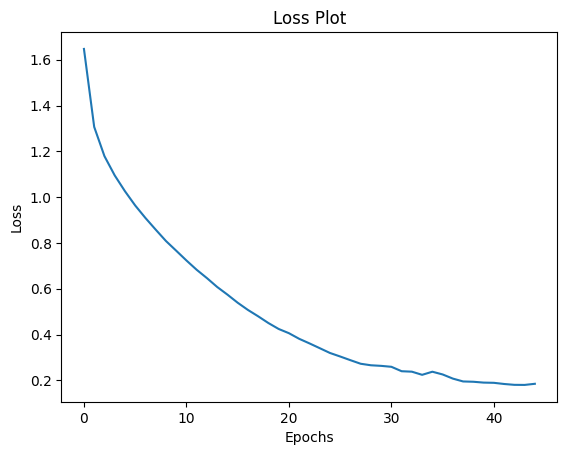

In [15]:
results = train_model(encoder, decoderLSTM, optimizer_LSTM, dataset, epochs = 50, early_stopping = 3)

# Affichage de la courbe d'entrainement
plt.plot(results[0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#results[2].save('models/encoder_model.keras')  
#results[3].save('models/decoder_LSTM_model.keras')

results[2].save_weights("models/encoder.weights.h5")
results[3].save_weights("models/decoder_lstm.weights.h5")

#results = train_model(encoder, decoderGRU, optimizer_GRU, dataset, epochs = 1, early_stopping = 10)
#
### Affichage de la courbe d'entrainement
#plt.plot(results[0])
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.title('Loss Plot')
#plt.show()
#
##results[3].save('models/decoder_GRU_model.keras')
#results[3].save_weights("models/decoder_gru.weights.h5")

---

#### Sauvegarde

In [16]:
from pathlib import Path

# saving
if not os.path.exists(f'{ProjectPath}/models/tokenizer_better.pickle'):
    Path(f'{ProjectPath}/models/tokenizer_better.pickle').touch()
with open(f'{ProjectPath}/models/tokenizer_better.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

---

#### Chargement

In [17]:
# loading
with open(f'{ProjectPath}/models/tokenizer_better.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [18]:
# Tu dois d'abord reconstruire les modèles (même structure qu'au training)
encoder_load = CNN_Encoder(embedding_dim)
decoder_load_lstm = RNN_Decoder(embedding_dim, units, vocab_size, use_lstm=True)
#decoder_load_gru = RNN_Decoder(embedding_dim, units, vocab_size, use_lstm=False)


# Build the models by calling them with dummy data
dummy_image_features = tf.random.normal([1, attention_features_shape, features_shape])
dummy_caption_input = tf.random.uniform([1, 1], minval=0, maxval=vocab_size, dtype=tf.int32)
dummy_hidden_state = tf.zeros((1, units))

# Build the encoder by calling it with dummy data
_ = encoder_load(dummy_image_features)

# Build the decoder by calling it with dummy data
dummy_encoder_output = encoder_load(dummy_image_features)
_ = decoder_load_lstm(dummy_caption_input, dummy_encoder_output, dummy_hidden_state)
#_ = decoder_load_gru(dummy_caption_input, dummy_encoder_output, dummy_hidden_state)


# Puis charger les poids
encoder_load.load_weights("models/encoder.weights.h5")
decoder_load_lstm.load_weights("models/decoder_lstm.weights.h5")
#decoder_load_gru.load_weights("models/decoder_gru.weights.h5")

---

#### Attention

In [19]:
# Function to display attention on the image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', 
        alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

---

Evaluation

In [20]:
def evaluate(image, decoder):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder_load(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        #temperature = 0.7  
        #predictions = predictions / temperature
        
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        
        result.append(tokenizer.index_word[predicted_id])
    
        if tokenizer.index_word[predicted_id] == '<end>':
            break
        
        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [21]:
# Fonction pour valider une légende
def is_valid_caption(caption):
    words = caption.split()

    # Critère 1 : au moins 5 mots
    if len(words) < 5:
        return False

    # Critère 2 : au moins 3 mots de au moins 5 lettres
    long_words = [w for w in words if len(w) >= 5]
    if len(long_words) < 3:
        return False

    # Critère 3 : pas plus de 2 occurrences du même mot
    lower_words = [w.lower() for w in words]
    word_counts = collections.Counter(lower_words)
    if any(count > 2 for count in word_counts.values()):
        return False

    return True

Image Path: /tf/dataset_livrable_3/train2014/train2014/COCO_train2014_000000539404.jpg
Real Caption: a small kitchen with a sink oven and microwave
LSTM Predictions:
LSTM Prediction 1: a picture of a kitchen with weird looking floors
LSTM Prediction 2: a small kithen with a refrigerator oven cupboards
LSTM Prediction 3: a kitchen with a small stove top oven
LSTM Prediction 4: a kitchen with a white appliances and someone on
LSTM Prediction 5: a small spotless kitchen with a refrigerator stove cabinets peel cabinets clutter


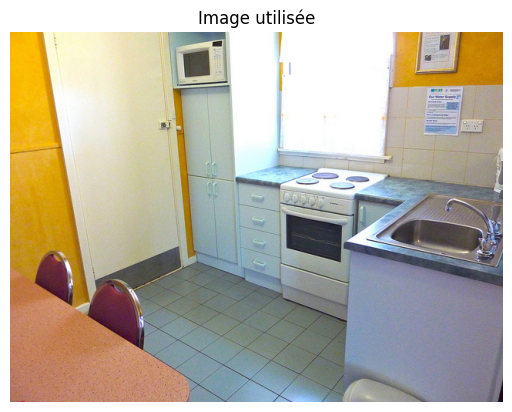

In [40]:
#import glob
#image_folder = "dataset_livrable_2/Results/denoised_photos/"
#image_files = glob.glob(f"{image_folder}/*.jpg")
#image = random.choice(image_files)
#index = None

#Choisir une image aléatoire
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
index = img_name_val.index(image)
real_caption = ' '.join([
    tokenizer.index_word[i]
    for i in cap_val[index]
    if i not in [0, tokenizer.word_index['<start>'], tokenizer.word_index['<end>']]
])

valid_captions_LSTM = []
valid_captions_GRU = []

# Boucle jusqu'à obtenir 5 captions valides par modèle
while len(valid_captions_LSTM) < 5:## or len(valid_captions_GRU) < 5:
    result_LSTM, attention_plot_LSTM = evaluate(image, decoder_load_lstm)
    #result_GRU, attention_plot_GRU = evaluate(image, decoder_load_gru)

    predicted_caption_LSTM = ' '.join([word for word in result_LSTM if word not in ['<start>', '<end>']])
    #predicted_caption_GRU = ' '.join([word for word in result_GRU if word not in ['<start>', '<end>']])

    if len(valid_captions_LSTM) < 5 and is_valid_caption(predicted_caption_LSTM):
        valid_captions_LSTM.append((predicted_caption_LSTM, attention_plot_LSTM))

    #if len(valid_captions_GRU) < 5 and is_valid_caption(predicted_caption_GRU):
    #    valid_captions_GRU.append((predicted_caption_GRU, attention_plot_GRU))

# Affichage final
print('Image Path:', image)
print('Real Caption:', real_caption)

# Affichage LSTM
print('LSTM Predictions:')
for i, (caption, attn) in enumerate(valid_captions_LSTM, 1):
    print(f'LSTM Prediction {i}:', caption)
    #plot_attention(image, caption.split(), attn)

# Affichage GRU
#print('GRU Predictions:')
#for i, (caption, attn) in enumerate(valid_captions_GRU, 1):
#    print(f'GRU Prediction {i}:', caption)
#    #plot_attention(image, caption.split(), attn)

# Afficher l'image originale
img = Image.open(image)
plt.imshow(img)
plt.axis("off")
plt.title("Image utilisée") 
plt.show()

# Metrics
#print('Precision score {}'.format(real_caption.split() - caption[0].split()))
#print('Recall score {}'.format(caption[0].split() - real_caption.split()))
#print('BLEU score -> {}'.format(sentence_bleu(real_caption.split(), caption[0].split())))
#Meteor TODO

In [41]:
# Metrics
bleus = []
rouges = []
meteors = []
CIDErs= []

#bleu = evaluate_metric.load("bleu", verbose=False)
meteor = evaluate_metric.load("meteor", verbose=False)
rouge = evaluate_metric.load("rouge", verbose=False)
#cider_scorer = Cider()
for i, (caption, attn) in enumerate(valid_captions_LSTM, 1):
    predictions = [caption]
    references = [[real_caption]]

    # BLEU
    smooth = SmoothingFunction().method4
    score = sentence_bleu(caption.split(), real_caption.split(), smoothing_function=smooth)
    bleus.append(score)

    # METEOR
    meteors.append(meteor.compute(predictions=predictions, references=references)["meteor"])

    # ROUGE
    rouges.append(rouge.compute(predictions=predictions, references=references)["rougeLsum"])

    gts = {
        "img1": [{"caption": real_caption}],
    }
    res = {
        "img1": [{"caption": caption[0]}],
    }

    # CIDEr & SPICE utilisent java et du coup peuvent faire des erreurs si pas installé ou pas la bonne version 

    # CIDEr
    # PTBtokenizer = PTBTokenizer()
    # gts = PTBtokenizer.tokenize(gts)
    # res = PTBtokenizer.tokenize(res)

    # score, scores = cider_scorer.compute_score(gts, res)
    # CIDErs.append(score)

    # SPICE
    # spice_scorer = Spice()
    # score, scores = spice_scorer.compute_score(gts, res)
    # print(f"SPICE: {score:.4f}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


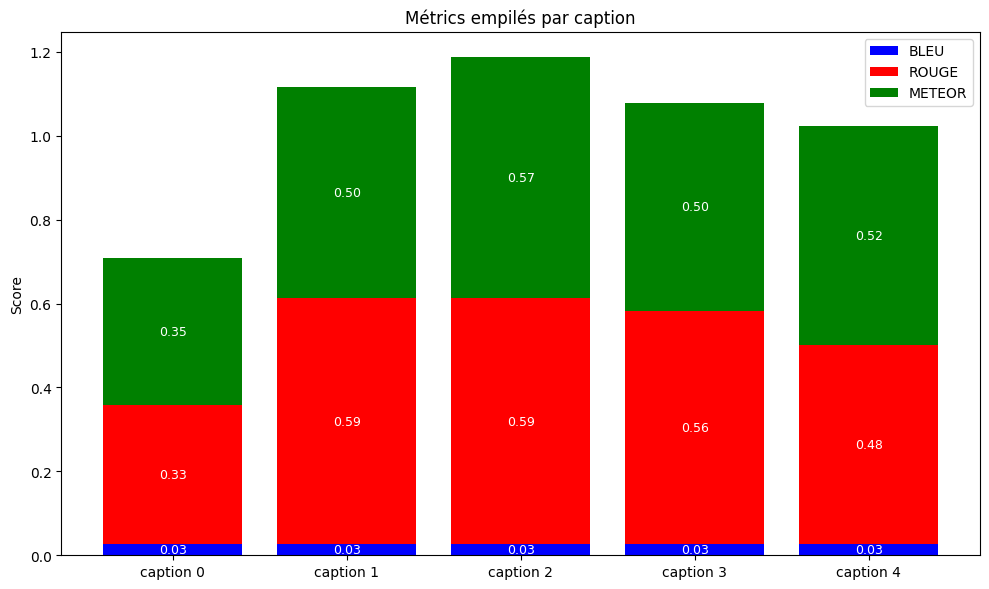

In [42]:
x = ["caption " + str(i) for i in range(len(bleus))]
metrics = [bleus, rouges, meteors] #, CIDErs]
labels = ['BLEU', 'ROUGE', 'METEOR'] #, 'CIDEr']
colors = ['blue', 'red', 'green'] #, 'orange']

plt.figure(figsize=(10, 6))
bottom = np.zeros(len(x))  # Hauteur de départ pour chaque segment

for i, (metric, name, color) in enumerate(zip(metrics, labels, colors)):
    bars = plt.bar(x, metric, bottom=bottom, label=name, color=color)

    # Annoter chaque segment
    for xi, yi, base in zip(x, metric, bottom):
        if yi > 0:
            plt.text(xi, base + yi / 2, f'{yi:.2f}', ha='center', va='center', fontsize=9, color='white')

    # Mise à jour de la hauteur de base
    bottom += metric

plt.ylabel('Score')
plt.title('Métrics empilés par caption')
plt.legend()
plt.tight_layout()
plt.show()